* https://uniswapv3book.com/index.html
* https://medium.com/@chaisomsri96/defi-math-uniswap-v3-concentrated-liquidity-bd87686b3ecf
* https://liobaheimbach.github.io/assets/pdf/Papers/Risks_and_Returns_of_Uniswap_V3_Liquidity_Providers.pdf
* https://docs.uniswap.org/sdk/v3/guides/advanced/active-liquidity
* https://blog.uniswap.org/uniswap-v3-math-primer
* https://blog.uniswap.org/uniswap-v3-math-primer-2
* https://atiselsts.github.io/pdfs/uniswap-v3-liquidity-math.pdf

In [1]:
from uniswappy import *
import pandas as pd
import copy
import matplotlib.pyplot as plt

user_nm = MockAddress().apply()
eth_amount = 10000
tkn_amount = 100000

fee = UniV3Utils.FeeAmount.MEDIUM
tick_spacing = UniV3Utils.TICK_SPACINGS[fee]
lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

In [2]:
def get_current_liquidity(lp, user, positions):
    _id = UniV3Utils.getPositionKey(user, lwr_tick, upr_tick)
    if(_id in positions):
        return positions[_id].liquidity
    else:
        return 0
        
def update_graph(lp, user, tkn, positions, graph):
    curr = get_current_liquidity(lp, user, positions)
    delta_liq = get_current_liquidity(lp, user, lp.positions) - curr
    #print(f'curr {curr}')
    if not user in graph:
        graph[user_add] = {} 
        graph[user_add]['price'] = lp.get_price(tkn)
        graph[user_add]['lwr_tick'] = lwr_tick
        graph[user_add]['upr_tick'] = upr_tick
        graph[user_add]['delta_liq'] = delta_liq
    else:  
        graph[user_add]['price'] = lp.get_price(tkn)
        graph[user_add]['lwr_tick'] = lwr_tick
        graph[user_add]['upr_tick'] = upr_tick
        graph[user_add]['delta_liq'] += delta_liq        


In [3]:
n_steps = 50
start_price = eth_amount/tkn_amount
mu = 0.1; sigma = 0.5
n_paths = 1

b = BrownianModel(start_price)
p_arr = b.gen_gbms(mu, sigma, n_steps, n_paths)
exp_p_arr = np.median(p_arr, axis = 1)

accounts = MockAddress().apply(250)

Text(0.5, 0, 'Date')

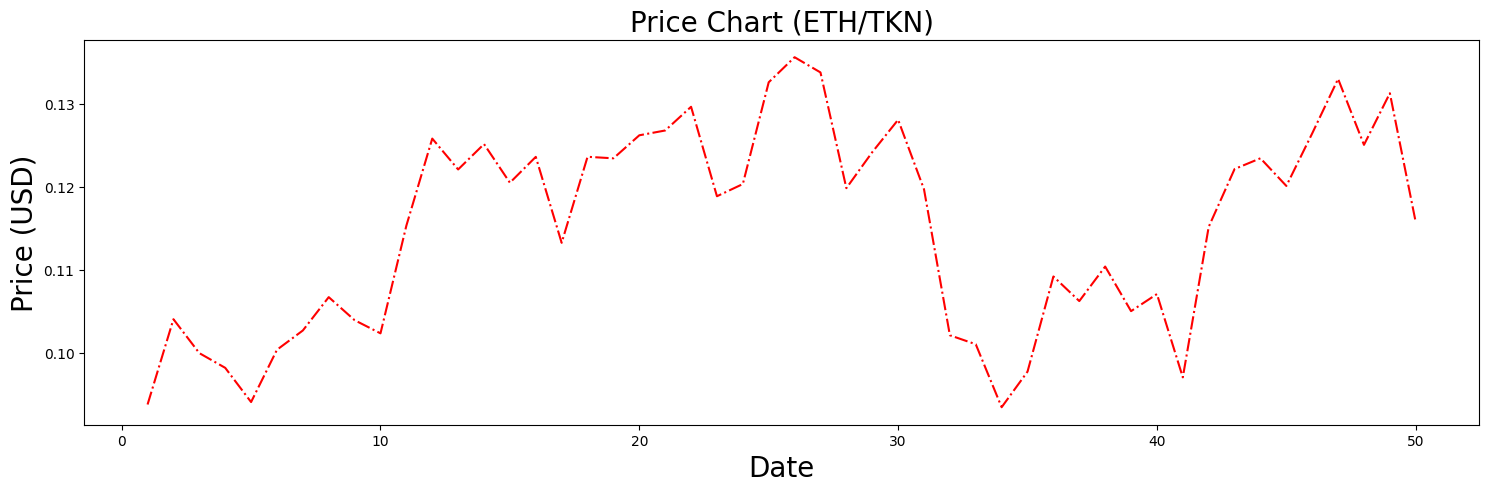

In [4]:
x_val = np.arange(0,len(p_arr))
fig, (USD_ax) = plt.subplots(nrows=1, sharex=False, sharey=False, figsize=(18, 5))
USD_ax.plot(x_val[1:], p_arr[1:], color = 'r',linestyle = 'dashdot', label='initial invest') 
USD_ax.set_title(f'Price Chart (ETH/TKN)', fontsize=20)
USD_ax.set_ylabel('Price (USD)', size=20)
USD_ax.set_xlabel('Date', size=20)

In [5]:
tkn = ERC20("TKN", "0x111")
eth = ERC20("ETH", "0x09")
exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", address="0x011")

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

Join().apply(lp, user_nm, eth_amount, tkn_amount)
lp.summary()

df_v2 = pd.DataFrame(columns = ['price', 'liq'])

Exchange ETH-TKN (LP)
Reserves: ETH = 10000, TKN = 100000
Liquidity: 31622.776601683792 



In [6]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()

    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)

    # Random trade volume  
    if(select_tkn == 0):
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt)
        df_v2 = pd.concat([df_v2,pd.DataFrame.from_dict({'price': [lp.get_price(tkn)], 'liq': [lp.last_liquidity_deposit]})])
        out = Swap().apply(lp, eth, user_nm, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt)
        df_v2 = pd.concat([df_v2,pd.DataFrame.from_dict({'price': [lp.get_price(tkn)], 'liq': [lp.last_liquidity_deposit]})])
        out = Swap().apply(lp, tkn, user_nm,  p*rnd_swap_amt)  
        
    
    #print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()


Exchange ETH-TKN (LP)
Reserves: ETH = 12103.89154614729, TKN = 92067.11829870961
Liquidity: 33316.55324390592 



In [7]:
df_v2.sort_values(by=['price'], inplace=True)
df_v2.reset_index(drop=True,inplace=True)
df_v2['price'] = np.round(df_v2['price'].values, 3)
freq_df_v2 = df_v2.groupby('price').agg({'liq': 'sum'})

In [8]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()
lp.ticks

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 100000.0
Gross Liquidity: 31622.776601683792 



{-887220: TickInfo(liquidityGross=31622776601683792000000, liquidityNet=31622776601683792000000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 887220: TickInfo(liquidityGross=31622776601683792000000, liquidityNet=-31622776601683792000000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0)}

In [9]:
lp.get_tick_price(-1, tick_space = 100)

22920

In [17]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)
#lwr_tick = lp.get_tick_price(-1, 10, 100000)
#upr_tick = lp.get_tick_price(1, 10, 100000)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

#lwr_tick = lp.get_tick_price(-1)
#upr_tick = lp.get_tick_price(1)

expected_amount_out = WithdrawSwap().apply(lp, tkn, user_nm, 1, lwr_tick, upr_tick)
lp.summary()
lp.ticks

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 100000.0
Gross Liquidity: 31622.776601683792 

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 9999.999999999998, TKN = 99998.99999999997
Gross Liquidity: 31622.61824987897 



{-887220: TickInfo(liquidityGross=31622618249878972559000, liquidityNet=31622618249878972559000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 887220: TickInfo(liquidityGross=31622618249878972559000, liquidityNet=-31622618249878972559000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0)}

In [14]:
lwr_tick = lp.get_tick_price(-1, 10, 100000)
lwr_tick

-76980

In [ ]:
4910.115856687737-4909.632911631716

In [ ]:
eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = UniV3Utils.getMinTick(tick_spacing)
upr_tick = UniV3Utils.getMaxTick(tick_spacing)

Join().apply(lp, user_nm, eth_amount, tkn_amount, lwr_tick, upr_tick)
lp.summary()

lwr_tick = lp.get_tick_price(-1)
upr_tick = lp.get_tick_price(1)

expected_amount_out = WithdrawSwap().apply(lp, tkn, user_nm, 100, lwr_tick, upr_tick)
lp.summary()

In [263]:
def calc_Lx(dx, lwr_tick, upr_tick):
    pa_sqrt_human = TickMath.getSqrtRatioAtTick(lwr_tick)/2**96
    pb_sqrt_human = TickMath.getSqrtRatioAtTick(upr_tick)/2**96 
    Lx = dx/(1/p_sqrt_human - 1/pb_sqrt_human)
    return Lx

def calc_Ly(dy, lwr_tick, upr_tick):
    pa_sqrt_human = TickMath.getSqrtRatioAtTick(lwr_tick)/2**96
    pb_sqrt_human = TickMath.getSqrtRatioAtTick(upr_tick)/2**96 
    Ly = 1000/(p_sqrt_human - pa_sqrt_human)
    return Ly

In [272]:
import math

eth = ERC20("ETH", "0x09")
tkn = ERC20("TKN", "0x111")
init_price = UniV3Utils.encodePriceSqrt(10, 1)

exchg_data = UniswapExchangeData(tkn0 = eth, tkn1 = tkn, symbol="LP", 
                                   address="0x011", version = 'V3', 
                                   tick_spacing = tick_spacing, 
                                   fee = fee)

factory = UniswapFactory("ETH pool factory", "0x2")
lp = factory.deploy(exchg_data)

lwr_tick = lp.get_tick_price(-1, 10, 1000)
upr_tick = lp.get_tick_price(1, 10, 1000)

Lx = calc_Lx(100, lwr_tick, upr_tick)
Ly = calc_Lx(1000, lwr_tick, upr_tick)

lp.initialize(init_price)
out = lp.mint(user_nm, lwr_tick, upr_tick, Ly)    #3162.2776601683795
lp.summary()

#out_v3 = lp.swapExact0For1(user_nm, 10, None)
#lp.summary()
out

Exchange ETH-TKN (LP)
Real Reserves:   ETH = 999.9999999999997, TKN = 10340.759310919504
Gross Liquidity: 66597.92378128914 



(999.9999999999997, 10340.759310919504)

In [273]:
lp.get_virtual_reserve(eth)

21060.112658716705

In [274]:
lp.get_virtual_reserve(tkn)

210601.1265871671

In [259]:
math.sqrt(1.0001**lwr_tick)

3.0070061633435934

In [248]:
calc_Ly(1000, lwr_tick, upr_tick)

6440.332066409042

In [207]:
p_sqrt_human = lp.slot0.sqrtPriceX96/2**96
p_sqrt_human

3.1622776601683795

In [220]:
p_sqrt_human = math.sqrt(10)
p_sqrt_human

3.1622776601683795

In [218]:
p_sqrt_human = math.sqrt(1.0001**mid_tick)
p_sqrt_human**2

11.021853767004924

9.042086066386357

11.021853767004924

In [231]:
dx = lp.get_liquidity()*(1/p_sqrt_human - 1/pb_sqrt_human)
dx

150.15483114479645

In [232]:
dy = lp.get_liquidity()*(p_sqrt_human - pa_sqrt_human)
dy

1552.7149682478614

In [182]:
lp.get_virtual_reserve(eth)

3162.277660168379

In [234]:
Lx = 100/(1/p_sqrt_human - 1/pb_sqrt_human)
Lx

6659.792378146566

In [237]:
Ly = 1000/(p_sqrt_human - pa_sqrt_human)
Ly

6440.332066409042

In [239]:
(Lx+Ly)/2

6550.062222277804

In [65]:
lp.get_reserve(eth)

484.83126809680334

99900.399301896

10009.97

In [31]:
63259.85082780032 - 63196.61638219618

63.23444560413918

In [27]:
arb = CorrectReserves(lp, x0 = 1/exp_p_arr[0])
for k in range(1, n_steps):
    p = 1/exp_p_arr[k]
    arb.apply(p, lwr_tick, upr_tick)
    
    select_tkn = EventSelectionModel().bi_select(0.5)
    rnd_swap_amt = TokenDeltaModel(30).delta()
    rnd_add_amt = TokenDeltaModel(30).delta()
    user_add = random.choice(accounts)
    user_swap = random.choice(accounts)
    v3_positions = copy.deepcopy(lp.positions)
    if(select_tkn == 0): 
        AddLiquidity().apply(lp, eth, user_add, rnd_add_amt, lp.get_tick_price(-1), lp.get_tick_price(1))
        update_graph(lp, user_add, tkn, v3_positions, v3_graph)
        out = Swap().apply(lp, eth, user_swap, rnd_swap_amt) 
    else:
        AddLiquidity().apply(lp, tkn, user_add, p*rnd_add_amt, lp.get_tick_price(-1), lp.get_tick_price(1))
        update_graph(lp, user_add, tkn, v3_positions, v3_graph)
        out = Swap().apply(lp, tkn, user_swap,  p*rnd_swap_amt) 

    print(f'Market: {exp_p_arr[k]}, LP: {lp.get_price(tkn)}')

print('')
lp.summary()

Market: 0.0937656024603014, LP: 0.09669480001667669
Market: 0.10403848404477221, LP: 0.10041233212852722
Market: 0.09995386616663228, LP: 0.09992528492315617
Market: 0.09818393340096576, LP: 0.09892762244899989
Market: 0.09406138265508736, LP: 0.09648298937493778
Market: 0.10036034882349122, LP: 0.09860993218600032
Market: 0.10268213899671788, LP: 0.10067793570735864
Market: 0.10669808357048871, LP: 0.10350921746019538
Market: 0.10392192760027019, LP: 0.1040902249477642
Market: 0.10233648882233831, LP: 0.10318880832324705
Market: 0.1153105970340253, LP: 0.10941695868450471
Market: 0.12579426427891122, LP: 0.11816931021695036
Market: 0.12207681732007515, LP: 0.12019152888795691
Market: 0.12513462056224892, LP: 0.12311335596588366
Market: 0.12047877596334462, LP: 0.12168791663207622
Market: 0.12359211091746825, LP: 0.12290261627280805
Market: 0.11323868878232184, LP: 0.11771939185663598
Market: 0.12360115183740894, LP: 0.12116499798791218
Market: 0.1234173369394383, LP: 0.122542297761054

In [28]:
lp.ticks

{3000: TickInfo(liquidityGross=32388153877981803966000, liquidityNet=32388153877981803966000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 43020: TickInfo(liquidityGross=32388153877981803966000, liquidityNet=-32388153877981803966000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 23280: TickInfo(liquidityGross=27805012127112472000, liquidityNet=-20155582989999280000, feeGrowthOutside0X128=3151694797444324950058077409604807, feeGrowthOutside1X128=19160117532184192125196010298619018),
 23400: TickInfo(liquidityGross=3824714568556596000, liquidityNet=-3824714568556596000, feeGrowthOutside0X128=0, feeGrowthOutside1X128=0),
 22920: TickInfo(liquidityGross=95156050726048144000, liquidityNet=-27176201786996000, feeGrowthOutside0X128=12448528319062002078637580971162516, feeGrowthOutside1X128=114048698341880152927113733637771986),
 23040: TickInfo(liquidityGross=55002026607030725000, liquidityNet=-40126847917230423000, feeGrowthOutside0X128=8454066581027086350997302607386776, feeGro

In [ ]:
lp.get_tick_price(1)

In [ ]:
lp.ticks

In [ ]:
UniV3Utils.getPositionKey(accounts[0], lwr_tick, upr_tick)

In [ ]:
lp.positions

In [ ]:
#for pos in v3_graph:
#    print(f"price {v3_graph[pos]['price']}, liq: {v3_graph[pos]['delta_liq']/10**18}")

In [ ]:
for k, pos in enumerate(v3_graph):
    row = np.empty(2)
    row[0] = v3_graph[pos]['price']
    row[1] = v3_graph[pos]['delta_liq']/10**18
    res = row if k == 0 else np.vstack((res, row))

df = pd.DataFrame(res, columns = ['price', 'liq'])
df.sort_values(by=['price'], inplace=True)
df.reset_index(drop=True,inplace=True)
df['price'] = np.round(df['price'].values, 3)
freq_df_v3 = df.groupby('price').agg({'liq': 'sum'})

In [ ]:
fig, (price_ax, ld_ax) = plt.subplots(nrows=2, sharex=False, sharey=False, figsize=(12, 10))

price_ax.plot(x_val[1:], p_arr[1:], color = 'r',linestyle = 'dashdot', label='initial invest') 
price_ax.set_title(f'Price Chart (ETH/TKN)', fontsize=15)
price_ax.set_ylabel('Price (USD)', size=14)
price_ax.set_xlabel('Date', size=10)

ld_ax.axvline(x = lp.get_price(tkn), color = 'red', linestyle = 'dashdot', linewidth=2, label = 'Last Price')
ld_ax.bar(freq_df_v2.index, freq_df_v2['liq'].values, color ='purple', width = 0.00095, alpha = .5, label = 'Uni V2')
ld_ax.bar(freq_df_v3.index, freq_df_v3['liq'].values, color ='teal', width = 0.00095, alpha = .5, label = 'Uni V3')
ld_ax.set_title('Liquidity Frequency Distribution: Uniswap V2 vs V3',fontsize=15)
ld_ax.set_ylabel('Liquidity', fontsize=14)
ld_ax.set_xlabel('Price (USD)', fontsize=10)
ld_ax.legend()